### Models - Popularity Score

In [82]:
# all of the imports
import pickle 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sea
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import boxcox
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from mpl_toolkits.mplot3d import axes3d, Axes3D
import warnings
warnings.filterwarnings('ignore')
import os
import time 
import numpy as np
import pandas as pd
import seaborn as sea
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from typing import Tuple
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import permutation_test_score
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
import json
import pickle
import warnings
import random
from rankit.Merge import borda_count_merge
warnings.filterwarnings('ignore')
sea.set()

In [2]:
# Import merged dataframe
data1 = pd.read_pickle('data/modelling_data.pkl')
imdb = pd.read_pickle("./data/imdb.pkl")
inflation = pd.read_csv("./data/InflationIndex.csv", index_col="Year")
data1.head(5)

,movie_name,release_date,theaters,budget,tmdb_popularity,revenue,runtime,votes,awards,genres,...,actor_popularity,,Approved,G,NC-17,Not Rated,PG,PG-13,R,Unrated
tt0029583,Snow White and the Seven Dwarfs1983 Re-release...,1983-07-15,1362.0,1488423.0,18.454,184925486.0,83.0,31717.0,17,"[Animation, Family, Fantasy]",...,4.941,0,0,1,0,0,0,0,0,0
tt0029583,Snow White and the Seven Dwarfs1987 Re-release...,1987-07-17,1729.0,1488423.0,18.454,184925486.0,83.0,31717.0,17,"[Animation, Family, Fantasy]",...,4.941,0,0,1,0,0,0,0,0,0
tt0029583,Snow White and the Seven Dwarfs1993 Re-release...,1993-07-02,1831.0,1488423.0,18.454,184925486.0,83.0,31717.0,17,"[Animation, Family, Fantasy]",...,4.941,0,0,1,0,0,0,0,0,0
tt0032455,Fantasia1985 Re-release (1985),1985-02-08,225.0,2280000.0,15.459,83320000.0,124.0,12247.0,9,"[Animation, Family, Fantasy]",...,5.211,0,0,1,0,0,0,0,0,0
tt0032455,Fantasia1990 Re-release (1990),1990-10-05,481.0,2280000.0,15.459,83320000.0,124.0,12247.0,9,"[Animation, Family, Fantasy]",...,5.211,0,0,1,0,0,0,0,0,0


In [3]:
def CPI_Index(year):
    new_cpi = inflation.loc[2019].values[0]
    old_cpi = inflation.loc[year].values[0]
    return ( new_cpi - old_cpi + 1) / old_cpi

In [4]:
data1['month'] = pd.DatetimeIndex(data1['release_date']).month
data1['year'] = pd.DatetimeIndex(data1['release_date']).year
data1["profit"] = data1["revenue"] - data1["budget"]
data1['profit'] = (data1['profit']*100 )/data1['year'].apply( lambda x: CPI_Index(x) )

In [5]:
data1.drop("tt6450804", inplace=True)

In [6]:
data1.columns

Index(['movie_name', 'release_date', 'theaters', 'budget', 'tmdb_popularity',
       'revenue', 'runtime', 'votes', 'awards', 'genres', 'imdb_popularity',
       'meta_score', 'mmpa_rating', 'reviews', 'ratings', 'actor_popularity',
       '', 'Approved', 'G', 'NC-17', 'Not Rated', 'PG', 'PG-13', 'R',
       'Unrated', 'month', 'year', 'profit'],
      dtype='object')

In [7]:
def handicrafted_scoring_function(row, weights):
    weight = list(weights.values())
    partial_scores = []
    for i in range(0,row.shape[0]):
        partial_scores.append( weight[i]* row[i] )
    return sum(partial_scores)

In [8]:
def BordaCountRanking(data_df, selected_cols, suffix=""):
    rank = []
    for cols in selected_cols:
        df = data_df[["index", cols]]
        df["rank"] = df[[cols]].rank( ascending=False)
        df.sort_values("rank", inplace = True)
        df = df.rename(columns={"index": "name", cols: "rating"})
        df["name"] = df["name"].astype("str")
        rank.append(df)

    mergedRankZ = borda_count_merge(rank)
    mergedRank = mergedRankZ.rename(columns={"name": "imdb_id"+suffix, "rank": "popularity_rank"+suffix, \
                                         "BordaCount":"borda_count"+suffix})
    return mergedRank

### Custom Ranking Model

In [9]:
custom_weight = data1.copy()
scaler = MinMaxScaler()
weights = { 
    'profit':0.8, 
    'tmdb_popularity':1.2, 
    'meta_score':0.75, 
    'votes': 0.6,
    'theaters':0.4, 
    'runtime' : 0.1,  
    'awards' : 0.05, 
    'actor_popularity' : 0.8, 
    'ratings' : 0.6, 
    'meta_score': 0.6
}

# Getting scores for scaled data 
scores = []
scaled_data = scaler.fit_transform(custom_weight[list(weights.keys())])
for i in range(scaled_data.shape[0]):
    scores.append(handicrafted_scoring_function(scaled_data[i], weights))
custom_weight["scores"] = scores

In [10]:
custom_weight["popularity"] = custom_weight['year'].apply(lambda x: 2019-x)*12+12
custom_weight["popularity"] = custom_weight["popularity"] - custom_weight['month']
custom_weight["popularity"] = custom_weight["popularity"].apply( lambda x: np.exp(-np.log(x)))
custom_weight["popularity"] = custom_weight["popularity"] * custom_weight["scores"]

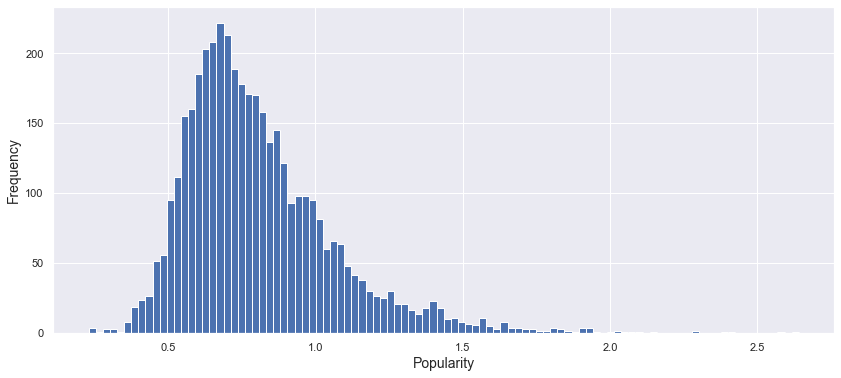

In [11]:
plt.figure(figsize=(14,6))
plt.hist(custom_weight["scores"],100)
plt.xlabel("Popularity",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.savefig("./images/score.png")
plt.show()

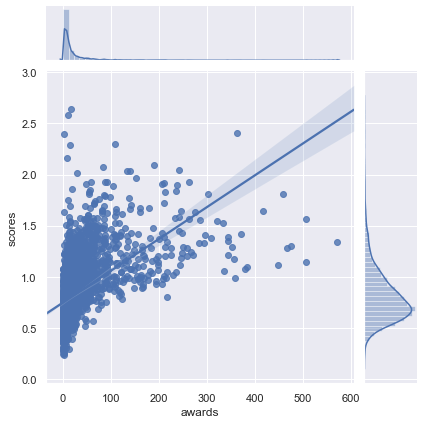

In [12]:
sea.jointplot("awards", "scores", data=custom_weight, kind='reg')

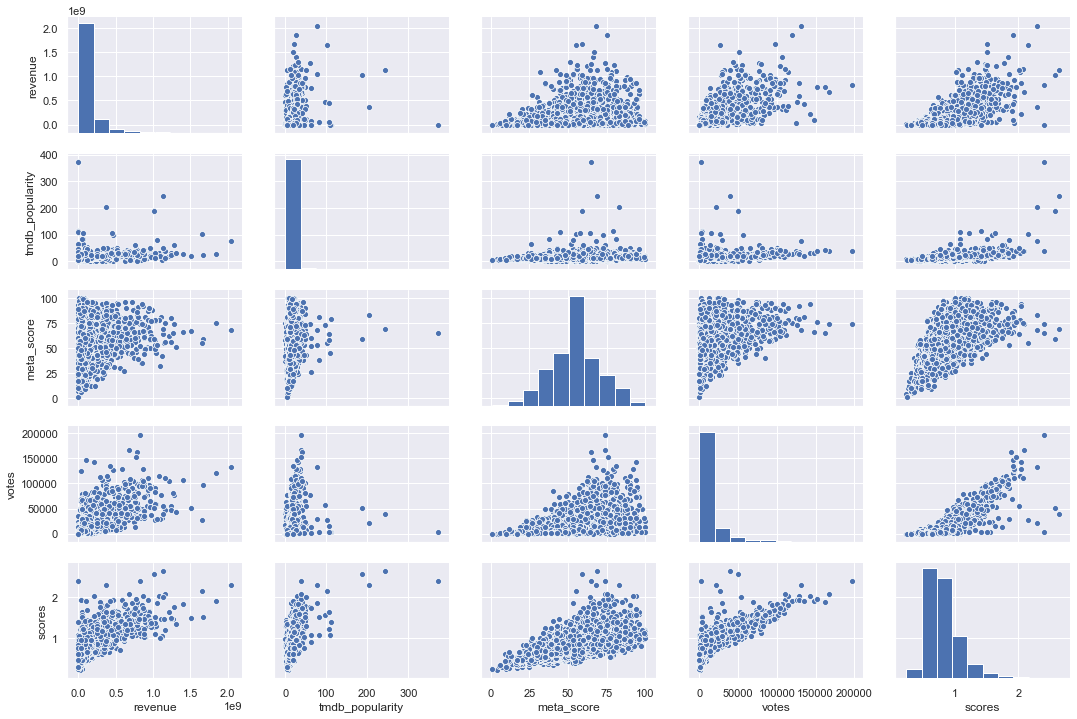

In [13]:
output = ["revenue", "tmdb_popularity", "meta_score", "votes", "scores"]
sea.pairplot(custom_weight[output], height=2, aspect=1.5)
plt.xlabel("",fontsize=14)
plt.ylabel("",fontsize=14)
plt.savefig('./images/popularity.png')

In [14]:
custom_weight[["movie_name", "release_date", "popularity"]].sort_values("popularity", ascending=False).head(10)

,movie_name,release_date,popularity
tt4520988,Frozen II (2019),2019-11-22,2.397824
tt1950186,Ford v Ferrari (2019),2019-11-15,1.510549
tt7286456,Joker (2019),2019-10-04,1.288424
tt5033998,Charlie's Angels (2019),2019-11-15,1.084271
tt3224458,A Beautiful Day in the Neighborhood (2019),2019-11-22,1.080087
tt5606664,Doctor Sleep (2019),2019-11-08,1.058390
tt6924650,Midway (2019),2019-11-08,0.892855
tt8623904,Last Christmas (2019),2019-11-08,0.838948
tt5563334,The Good Liar (2019),2019-11-15,0.823871
tt4648786,Harriet (2019),2019-11-01,0.742578


In [15]:
custom_weight[custom_weight.awards > 500]

,movie_name,release_date,theaters,budget,tmdb_popularity,revenue,runtime,votes,awards,genres,...,Not Rated,PG,PG-13,R,Unrated,month,year,profit,scores,popularity
tt2024544,12 Years a Slave (2013),2013-10-18,1474.0,20000000.0,16.773,187000000.0,134.0,56263.8,571,"[Biography, Drama, History]",...,0,0,0,1,0,10,2013,2.351679e+11,1.339014,0.018095
tt3783958,La La Land (2016),2016-12-09,3236.0,30000000.0,23.473,445435700.0,129.0,85193.6,507,"[Comedy, Drama, Music]",...,0,0,1,0,0,12,2016,1.050326e+12,1.568115,0.043559
tt4975722,Moonlight (2016),2016-10-21,1564.0,4000000.0,16.394,65046687.0,111.0,31664.6,507,[Drama],...,0,0,0,1,0,10,2016,1.543414e+11,1.142539,0.030067


In [16]:
def pops(x):
    if x < 10:
        return "Less than 10"
    elif x >=10 and x < 50:
        return "10 to 50"
    elif x >=50 and x < 100:
        return "50 to 100"
    elif x >=100 and x < 200:
        return "100 to 200"
    elif x >=200 and x < 250:
        return "200 to 250"
    elif x >=250 and x < 500:
        return "250 to 500"
    else :
        return "500 and beyond"
    
custom_weight["Number of Awards"] = custom_weight["awards"].apply( lambda x: pops(x))

In [17]:
custom_weight = custom_weight[custom_weight.popularity < 0.1]
custom_weight = custom_weight[custom_weight.awards > 0]

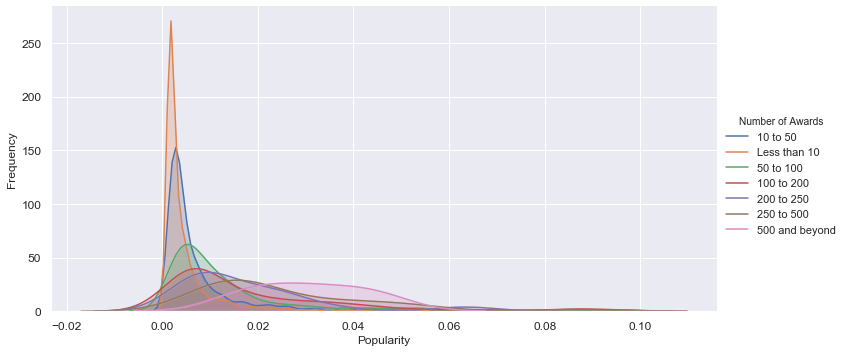

In [18]:
(sea.FacetGrid(custom_weight[(custom_weight['Number of Awards']\
                        .isin(custom_weight['Number of Awards']\
                              .value_counts().index.values))],
               hue='Number of Awards', height=5, aspect=2)
  .map(sea.kdeplot, 'popularity', shade=True)
 .add_legend()
)
plt.xlabel("Popularity",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./images/awards.png")
plt.show()

### Modified Decay Lay

In [19]:
data = data1.reset_index()
scaler = MinMaxScaler()

In [20]:
pre_cols = {'theaters':0.5, 'profit':0.8, 'runtime':0.2,  'awards':0.4, 'actor_popularity':0.6}
post_cols = {'tmdb_popularity':0.8, 'votes':0.6, "imdb_popularity":0.2, 'ratings':0.5, 'meta_score':0.4}
   
scores = []
pre_scaled_data = scaler.fit_transform(data[list(pre_cols.keys())])
for i in range(pre_scaled_data.shape[0]):
    scores.append(handicrafted_scoring_function(pre_scaled_data[i], pre_cols))
data["pre_score"] = scores

scores = []
post_scaled_data = scaler.fit_transform(data[list(post_cols.keys())])
for i in range(post_scaled_data.shape[0]):
    scores.append(handicrafted_scoring_function(post_scaled_data[i], post_cols))
data["post_score"] = scores

In [21]:
data["popularity"] = data['year'].apply(lambda x: 2019-x)*12+12
data["popularity"] = data["popularity"] - data['month']
data["temp"] = data["post_score"] - data["pre_score"]
data["temp"] = data["temp"]*np.log(data["popularity"])
data["temp"] = data["temp"].apply( lambda x: np.exp(x))
data["popularity"] = data["pre_score"] * data["temp"]

In [22]:
data[["movie_name", "release_date", "popularity"]].sort_values("popularity", ascending=False).head(10)

,movie_name,release_date,popularity
1671,The Shawshank Redemption (1994),1994-09-23,149.172143
1662,Pulp Fiction (1994),1994-10-14,31.501592
72,Star Wars: Episode IV - A New Hope1982 Re-rele...,1982-08-13,17.712057
2134,Fight Club (1999),1999-10-15,16.906025
1632,The Lion King (1994),1994-06-15,13.466264
238,Star Wars: Episode V - The Empire Strikes Back...,1982-11-19,9.646680
73,Star Wars: Episode IV - A New Hope1997 Special...,1997-01-31,7.911143
1633,The Lion King2011 3D Release (2011),2011-09-16,7.270275
298,The Shining (1980),1980-05-23,7.192302
2032,The Lord of the Rings: The Fellowship of the R...,2001-12-19,6.672687


In [23]:
year_raging_bull = 2020 - data[data.movie_name == "Inception (2010)"]["year"].values[0]
ini_popularity = data[data.movie_name == "Inception (2010)"]["popularity"].values[0]

In [24]:
pou_list = []
for i in range(int(year_raging_bull)):
    popu = {}
    popu["year"] = 2010+i
    popu["popularity"] = np.log(ini_popularity)*np.exp(-(i+1))
    pou_list.append(popu)

popu_df = pd.DataFrame(pou_list)
popu_df.head()

,popularity,year
0,0.620586,2010
1,0.228301,2011
2,0.083987,2012
3,0.030897,2013
4,0.011366,2014


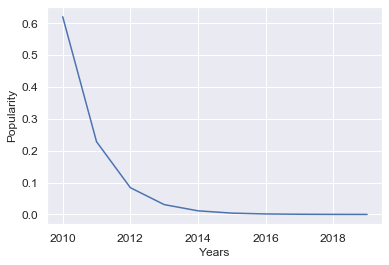

In [25]:
sea.lineplot(x="year", y="popularity", data=popu_df)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Popularity",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./images/Inception.png")
plt.show()

### Borda Count Method + Decay Law

In [26]:
data = data1.reset_index()
selected_cols = ['theaters', 'profit', 'runtime',  'awards', 'tmdb_popularity', 
                'votes', 'actor_popularity', 'ratings', 'meta_score']
    
mergedRank = BordaCountRanking(data, selected_cols)

In [27]:
data.set_index("index", inplace=True)
mergedRank.set_index("imdb_id", inplace=True)
df = mergedRank.merge(data, how="left", left_index=True, right_index=True)\
        .sort_values("borda_count", ascending=False)

In [28]:
df["popularity"] = df['year'].apply(lambda x: 2019-x)*12+12
df["popularity"] = df["popularity"] - df['month']
df["popularity"] = df["popularity"].apply( lambda x: np.exp(-np.log(x)))
df["popularity"] = df["popularity"] * df["borda_count"]

In [29]:
df.drop(df[(df.year == 2019) & (df.budget == 0) ].index, inplace=True)

In [30]:
df[["movie_name", "release_date", "popularity"]].sort_values("popularity", ascending=False).head(10)

,movie_name,release_date,popularity
tt1950186,Ford v Ferrari (2019),2019-11-15,26155.00
tt6924650,Midway (2019),2019-11-08,18272.50
tt3224458,A Beautiful Day in the Neighborhood (2019),2019-11-22,17819.00
tt7286456,Joker (2019),2019-10-04,16752.50
tt8623904,Last Christmas (2019),2019-11-08,14034.50
tt6751668,Parasite (2019),2019-10-11,13093.00
tt4777008,Maleficent: Mistress of Evil (2019),2019-10-18,12813.50
tt7349950,It Chapter Two (2019),2019-09-06,10087.50
tt1560220,Zombieland: Double Tap (2019),2019-10-18,9740.25
tt1025100,Gemini Man (2019),2019-10-11,9669.00


In [31]:
df.shape

(4223, 31)

In [32]:
# df.loc[ "tt4520988"]

In [33]:
df.to_csv("./data/movies.csv")

In [34]:
year_raging_bull = 2020 - df[df.movie_name == "Inception (2010)"]["year"].values[0]
ini_popularity = df[df.movie_name == "Inception (2010)"]["borda_count"].values[0]

In [35]:
pou_list = []
for i in range(int(year_raging_bull)):
    popu = {}
    popu["year"] = 2010+i
    popu["popularity"] = np.log(ini_popularity)*np.exp(-(i+1))
    pou_list.append(popu)

popu_df = pd.DataFrame(pou_list)
popu_df.head()

,popularity,year
0,3.861664,2010
1,1.420627,2011
2,0.522619,2012
3,0.192261,2013
4,0.070729,2014


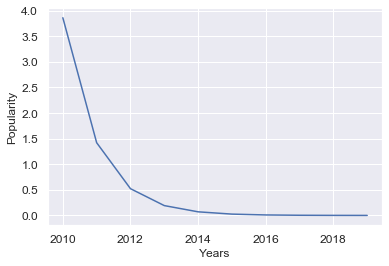

In [36]:
sea.lineplot(x="year", y="popularity", data=popu_df)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Popularity",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./images/Inception.png")
plt.show()

In [37]:
min_year = min(df["year"])
max_year = max(df["year"])
for i in range(1980, 2019, 10):
    blah = df[(df['year'] < i+10) & (df['year'] >= i)].\
                    sort_values("popularity" )\
                    [["movie_name", "popularity", "year"]].head(10).values
    print("The bottom 10 movies between %d and %d in order of popularity are the following" %(i, i+9))
    index = 1
    for i in blah:
        print(str(index)+". "+i[0])
        index = index + 1
    print()

The bottom 10 movies between 1980 and 1989 in order of popularity are the following
1. King of the Mountain (1981)
2. Student Bodies (1981)
3. Hardbodies (1984)
4. The Gong Show Movie (1980)
5. Jekyll and Hyde... Together Again (1982)
6. Alphabet City (1984)
7. Gilda Live (1980)
8. Modern Problems (1981)
9. The Smurfs and the Magic Flute (1983)
10. Krush Groove (1985)

The bottom 10 movies between 1990 and 1999 in order of popularity are the following
1. Across the Sea of Time (1995)
2. T-Rex: Back to the Cretaceous (1998)
3. Ernest Goes to Jail (1990)
4. Wings of Courage (1995)
5. The Perfect Weapon (1991)
6. Ernest Scared Stupid (1991)
7. The First Power (1990)
8. Once Upon a Crime... (1992)
9. Bébé's Kids (1992)
10. House Party 3 (1994)

The bottom 10 movies between 2000 and 2009 in order of popularity are the following
1. Double Take (2001)
2. NASCAR: The IMAX Experience (2004)
3. Michael Jordan to the Max (2000)
4. Two Can Play That Game (2001)
5. Corky Romano (2001)
6. Jonah: A V

In [38]:
imdb = pd.read_pickle("./data/imdb.pkl")

In [39]:
movies = []
for i,j in imdb[["cast_ids", "tconst"]].values:
    if "nm0000093" in i:
        movies.append(j)

df1 = df.loc[movies]

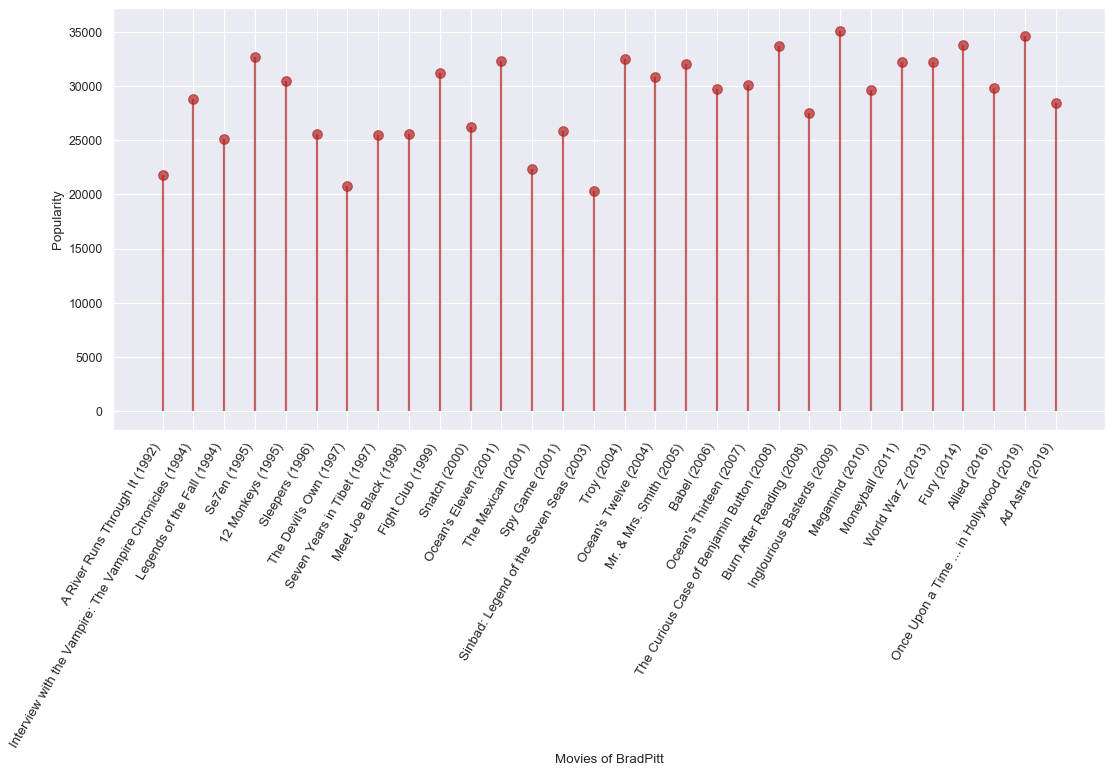

In [40]:
fig, ax = plt.subplots(figsize=(16,7), dpi= 80)
ax.vlines(x=df1.index, ymin=0, ymax=df1.borda_count, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=df1.index, y=df1.borda_count, s=75, color='firebrick', alpha=0.7)
# Title, Label, Ticks and Ylim
ax.set_ylabel('Popularity', size=12)
ax.set_xlabel('Movies of BradPitt', size=12)
ax.set_xticks(df1.index)
ax.set_xticklabels(df1.movie_name, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
# ax.set_ylim(0, 30)
# Annotate
plt.savefig("./images/BradPitt.png")
plt.show()

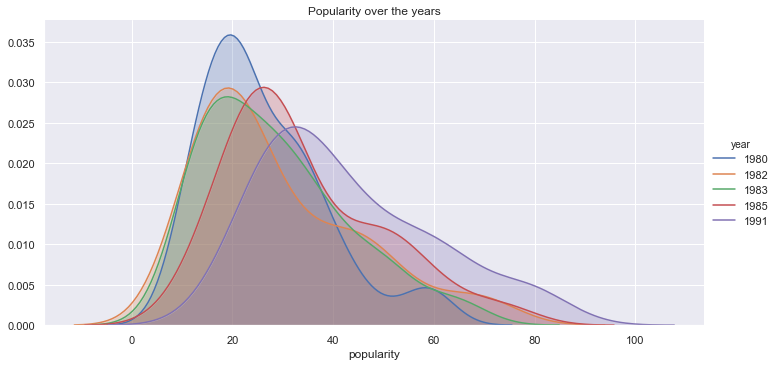

In [41]:
(sea.FacetGrid(df[(df['year']\
                        .isin(df['year']\
                              .value_counts()[:5].index.values))],
               hue='year', height=5, aspect=2)
  .map(sea.kdeplot, 'popularity', shade=True)
 .add_legend()
)
plt.title("Popularity over the years")
plt.show()

In [42]:
len(movies)

30

In [43]:
def Linear_Regression(X_train, y_train, X_validate):
    # Fitting and predicting
    lr = LinearRegression()
    linear_regression = lr.fit(X_train, y_train)
    y = lr.predict(X_validate)
    return y,linear_regression

def Logestic_Regression(X_train, y_train, X_validate):
    # Fitting and predicting
    lr = LinearRegression()
    linear_regression = lr.fit(X_train, y_train)
    y = lr.predict(X_validate)
    return y,linear_regression


# Label Encoding for training and testing data
def Label_Encoder(data, labelEncoding):
    # Initialization
    lb = LabelEncoder()
    
    # Setting fields as Categorical & label encoding
    for feature in labelEncoding :
        if feature in data:
            data[feature] = pd.Categorical(data[feature])
            data[feature] = lb.fit_transform(data[feature].astype(str))
    return data
    

# Funciton to calculate Root Mean Sqaure Logorithmic Error
def RootMeanSquaredLogorithmicError(actual, predicted):
    return np.sqrt(mean_squared_log_error( actual, predicted ))

# Funciton to calculate Root Mean Sqaure Logorithmic Error
def RootMeanSquaredError(actual, predicted):
    return np.sqrt(mean_squared_error( actual, predicted ))

def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_validate, y_train, y_validate = \
        train_test_split(X, y, test_size=0.4, random_state=78)
    
    # fit linear regression to training data
    y_predicted,linear_regression = Linear_Regression(X_train, y_train, X_validate)
    
    # score fit model on validation data
    val_score = linear_regression.score(X_validate, y_validate)
    rmsle = RootMeanSquaredError(y_validate, y_predicted)
    
    print('\nValidation R^2 score was:', val_score)
    print("RMSE Score of Linear Regression Model is %s" % rmsle )

In [44]:
df.columns

Index(['borda_count', 'popularity_rank', 'movie_name', 'release_date',
       'theaters', 'budget', 'tmdb_popularity', 'revenue', 'runtime', 'votes',
       'awards', 'genres', 'imdb_popularity', 'meta_score', 'mmpa_rating',
       'reviews', 'ratings', 'actor_popularity', '', 'Approved', 'G', 'NC-17',
       'Not Rated', 'PG', 'PG-13', 'R', 'Unrated', 'month', 'year', 'profit',
       'popularity'],
      dtype='object')

In [45]:
y = df["popularity"]
X = df.drop(["popularity", "movie_name", "release_date", "genres", "mmpa_rating", "popularity_rank" ], axis=1)

In [46]:
X_train, X_validate, y_train, y_validate = \
        train_test_split(X, y, test_size=0.9, random_state=32)

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_validate)

In [48]:
RootMeanSquaredError(y_validate,y_pred)

760.0577719382173

In [49]:
import scipy.stats as stats
def diagnostic_plot(x, y, model):
    plt.figure(figsize=(20,5))
    pred = model.predict(x)
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

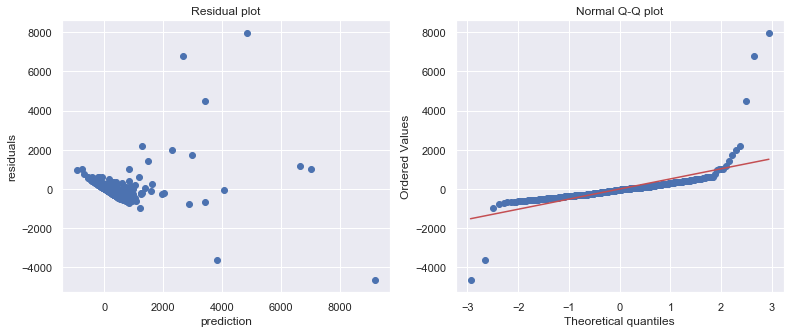

In [50]:
diagnostic_plot(X_train, y_train, lr)

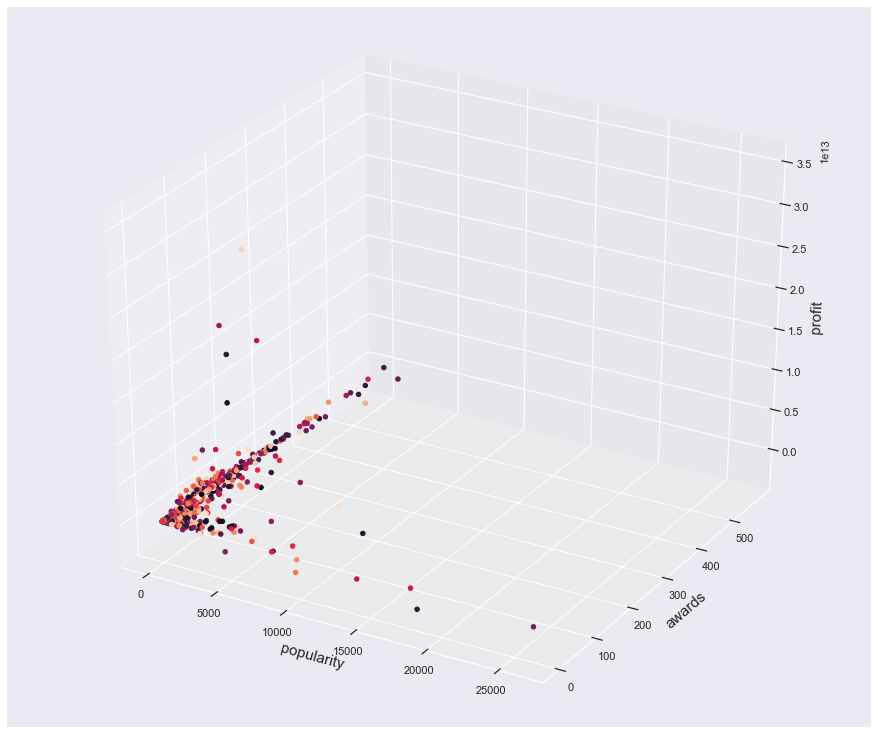

In [51]:
fig, ax = plt.subplots(1,2,figsize=(12,10))
plt.subplot(1,2,1)
ax = Axes3D(fig)
colors = np.random.rand(len(df))

xs = np.array(df['popularity'])
ys = np.array(df['awards'])
zs = np.array(df['profit'])
ax.scatter(xs,ys, zs, c= colors,marker='o', alpha=1)

ax.set_xlabel('popularity', size=15)
ax.set_ylabel('awards',size=15)
ax.set_zlabel('profit',size=15)


plt.savefig("./images/awards3d.png")
plt.show()

In [78]:
mean_train_dataframe = custom_weight.mean()
cms = custom_weight.fillna(mean_train_dataframe)
y = cms["popularity"]
X = cms[selected_cols]
X_train, X_validate, y_train, y_validate = \
        train_test_split(X, y, test_size=0.9, random_state=32)

# Function to calculate Root Mean Sqaure Logorithmic Error
def RootMeanSquaredLogorithmicError(actual, predicted):
    return np.sqrt(mean_squared_log_error( actual, predicted ))

# Function to calculate Root Mean Sqaure Logorithmic Error
def RootMeanSquaredError(actual, predicted):
    return np.sqrt(mean_squared_error( actual, predicted ))


model_linear = LinearRegression()
train_model_linear = model_linear.fit(X_train, y_train)
train_output_linear = train_model_linear.predict(X_validate)
rmse_linear = RootMeanSquaredError(y_validate, train_output_linear)
print("Linear", rmse_linear)

model_grb = GradientBoostingRegressor()
train_model_grb = model_grb.fit(X_train, y_train)
train_output_grb = train_model_grb.predict(X_validate)
rmse_grb = RootMeanSquaredError(y_validate, train_output_grb)
print("Gradient Boost", rmse_grb)

model_xgb = xgb.XGBRegressor()
train_model_xgb = model_xgb.fit(X_train, y_train)
train_output_xgb = train_model_xgb.predict(X_validate)
rmse_xgb = RootMeanSquaredError(y_validate, train_output_xgb)
print("XGB", rmse_xgb)

model_random_forest = RandomForestRegressor(n_estimators=1000)
train_model_random_forest = model_random_forest.fit(X_train, y_train)
train_output_random_forest = train_model_random_forest.predict(X_validate)
rmse_random_forest = RootMeanSquaredError(y_validate, train_output_random_forest)
print("random forest", rmse_random_forest)

model_ada = AdaBoostRegressor()
train_model_ada = model_ada.fit(X_train, y_train)
train_output_ada = train_model_ada.predict(X_validate)
rmse_ada = RootMeanSquaredError(y_validate, train_output_ada)
print("ADA", rmse_ada)

Linear 0.0089323863458209
Gradient Boost 0.007930004072299749
[21:41:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB 0.008085771105625422
random forest 0.00820236992355503
ADA 0.009093437091349434


In [56]:
df.columns

Index(['borda_count', 'popularity_rank', 'movie_name', 'release_date',
       'theaters', 'budget', 'tmdb_popularity', 'revenue', 'runtime', 'votes',
       'awards', 'genres', 'imdb_popularity', 'meta_score', 'mmpa_rating',
       'reviews', 'ratings', 'actor_popularity', '', 'Approved', 'G', 'NC-17',
       'Not Rated', 'PG', 'PG-13', 'R', 'Unrated', 'month', 'year', 'profit',
       'popularity'],
      dtype='object')

In [76]:
mean_train_dataframe = df.mean()
dfs = df.fillna(mean_train_dataframe)
y = dfs["popularity"]
X = df.drop(["popularity", "movie_name", "release_date", "genres", "mmpa_rating", "popularity_rank" ], axis=1)
X_train, X_validate, y_train, y_validate = \
        train_test_split(X, y, test_size=0.9, random_state=32)

# Function to calculate Root Mean Sqaure Logorithmic Error
def RootMeanSquaredLogorithmicError(actual, predicted):
    return np.sqrt(mean_squared_log_error( actual, predicted ))

# Function to calculate Root Mean Sqaure Logorithmic Error
def RootMeanSquaredError(actual, predicted):
    return np.sqrt(mean_squared_error( actual, predicted ))


model_linear = LinearRegression()
train_model_linear = model_linear.fit(X_train, y_train)
train_output_linear = train_model_linear.predict(X_validate)
rmse_linear = RootMeanSquaredError(y_validate, train_output_linear)
print("Linear", rmse_linear)

model_grb = GradientBoostingRegressor()
train_model_grb = model_grb.fit(X_train, y_train)
train_output_grb = train_model_grb.predict(X_validate)
rmse_grb = RootMeanSquaredError(y_validate, train_output_grb)
print("Gradient Boost", rmse_grb)

model_xgb = xgb.XGBRegressor()
train_model_xgb = model_xgb.fit(X_train, y_train)
train_output_xgb = train_model_xgb.predict(X_validate)
rmse_xgb = RootMeanSquaredError(y_validate, train_output_xgb)
print("XGB", rmse_xgb)

model_random_forest = RandomForestRegressor(n_estimators=1000)
train_model_random_forest = model_random_forest.fit(X_train, y_train)
train_output_random_forest = train_model_random_forest.predict(X_validate)
rmse_random_forest = RootMeanSquaredError(y_validate, train_output_random_forest)
print("random forest", rmse_random_forest)

model_ada = AdaBoostRegressor()
train_model_ada = model_ada.fit(X_train, y_train)
train_output_ada = train_model_ada.predict(X_validate)
rmse_ada = RootMeanSquaredError(y_validate, train_output_ada)
print("ADA", rmse_ada)

Linear 760.0577719382173
Gradient Boost 442.884498147593
[21:41:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB 438.5569896351814
random forest 458.16432501894064
ADA 486.68160515152584


In [65]:
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess


def gradient_squared_log(predt, y):
        return (np.log1p(predt) - np.log1p(y)) / (predt + 1)
def hessian_squared_log(predt, y):
        return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))
def squared_log_mince(predt, y):
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

def rmsle_mince(predt,y):
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

print("Done")

Done


In [79]:

# https://xgboost.readthedocs.io/en/latest/parameter.html#
# TODO squaredlogerror would be great here - log of budget is important
clfs = [
        (xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 60), "XGBoost linear tweaked 2", r2_score),
        (DummyRegressor(), "dummy", r2_score),
        (MLPRegressor(solver='lbfgs'), "Multi-layer perceptron", r2_score),
        (KNeighborsRegressor(), "KNN", r2_score),
        (KNeighborsRegressor(n_neighbors=10), "KNN, 10 neighbors", r2_score),
#         (LinearRegression(), "linear", r2_score),
        (RandomForestRegressor(n_estimators=60, max_depth=10), "Random Forest", r2_score),
#         (GaussianNB(), "Gaussian Naive Bayes", r2_score)
       ]

for clf, clf_name, objective in clfs:
    print ("For clf", clf_name, ":")
    print("Fitting...")
    model = clf.fit(X_train,y_train)
    print("Predicting...")
    preds = model.predict(X_validate)
    print("Calculating RMSE...")
    rmse = np.sqrt(mean_squared_error(y_validate, preds))
    print("RMSE: %f" % (rmse))
    print("objective score test: ", objective(y_validate, preds))
    print("Done.\n\n")

For clf XGBoost linear tweaked 2 :
Fitting...
[21:41:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Predicting...
Calculating RMSE...
RMSE: 0.008991
objective score test:  0.47969807253922403
Done.


For clf dummy :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 0.012469
objective score test:  -0.0006508879460094263
Done.


For clf Multi-layer perceptron :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 148551.677452
objective score test:  -142022363536043.47
Done.


For clf KNN :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 0.008694
objective score test:  0.5135361495044641
Done.


For clf KNN, 10 neighbors :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 0.008748
objective score test:  0.5075001845054135
Done.


For clf Random Forest :
Fitting...
Predicting...
Calculating RMSE...
RMSE: 0.008300
objective score test:  0.5566257814012228
Done.




In [75]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 100)

print("Fitting...")
xg_reg.fit(X_train,y_train)
print("Predicting...")
preds = xg_reg.predict(X_validate)
print("Calculating RMSE...")
rmse = np.sqrt(mean_squared_error(y_validate, preds))
print("RMSE: %f" % (rmse))
np.corrcoef(y_validate, preds)

from sklearn.metrics import r2_score
print("R2 score test: ", r2_score(y_validate, preds))
print("R^2 score (train): ", r2_score(y_train, xg_reg.predict(X_train)))

Fitting...
[21:38:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Predicting...
Calculating RMSE...
RMSE: 560.218755
R2 score test:  0.6383294476279548
R^2 score (train):  0.9999840193565116


In [87]:

model_grb = DecisionTreeRegressor()
train_model_grb = model_grb.fit(X_train, y_train)
train_output_grb = train_model_grb.predict(X_validate)
rmse_grb = RootMeanSquaredError(y_validate, train_output_grb)


In [88]:
rmse_grb

0.009614175293999074